# Violence in Mexico

This notebook is to shed some light on the violence in Mexico. We'll discuss which ones are the most violent states and the trend of violence. The notebook will consist on a general trends of murders. We'll investigate which are the most dominant types of murders.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('IDEFC_NM_may22.csv')

In [3]:
mrdr_all = df[df['Tipo de delito'] == "Homicidio"].drop('Subtipo de delito',axis = 1)

In [4]:
len(df.Entidad.unique())

32

In [5]:
mrdr_all.rename(columns = {'A�o':"anio"},inplace= True)
years = mrdr_all['anio'].unique()
months = mrdr_all.columns[-12::]

In [6]:
for column in months:
    mrdr_all[column] = mrdr_all[column].map(lambda x: np.nan_to_num(x))
mrdr_all['all'] = [np.sum([mrdr_all[col][i] for col in months]) for i in mrdr_all.index]    

In [7]:
def change_name(x):

    inc_states = ['Ciudad de M�xico','M�xico','Nuevo Le�n','San Luis Potos�','Coahuila de Zaragoza','Michoac�n de Ocampo','Quer�taro','San Luis Potos�',
                    'Veracruz de Ignacio de la Llave','Yucat�n']
    corr_names = ['Ciudad de Mexico','Mexico','Nuevo Leon','San Luis Potosi','Coahuila','Michoacan','Queretaro','San Luis Potosi',
                    'Veracruz','Yucatan']

    if x in inc_states:
        
        mask = np.array(x == np.array(inc_states))

        return np.array(corr_names)[mask][0]
    return x

#correct the names

In [8]:
mrdr_all['Entidad'] = mrdr_all['Entidad'].map(lambda x: change_name(x))

<AxesSubplot:xlabel='anio'>

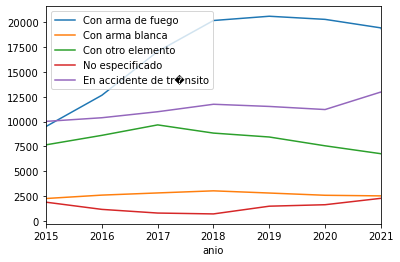

In [9]:
types = mrdr_all.Modalidad.unique()
types_mrdrs = pd.DataFrame()
for mrdr,year in zip(types,years):
    dF = mrdr_all[mrdr_all["Modalidad"]== mrdr].groupby('anio').sum()
    types_mrdrs[mrdr] = dF['all']

types_mrdrs.plot(y=types,xlim = (2015,2021))

From the figure, it can be appreciated that murders with fire arms have been the predominant way of murder in Mexico from 2015 to 2021. The values from 2022 are incomplete so we can't have a good comparison at the moment. We'll discuss the ongoing figures later in this notebook.

In [10]:
mrdr_gun = mrdr_all[mrdr_all.Modalidad == "Con arma de fuego"].drop("Modalidad",axis=1).drop("Bien jur�dico afectado",axis=1)

In [11]:
mrdr_gun['all'] = [np.sum([mrdr_gun[col][i] for col in months]) for i in mrdr_gun.index]

(2015.0, 2021.0)

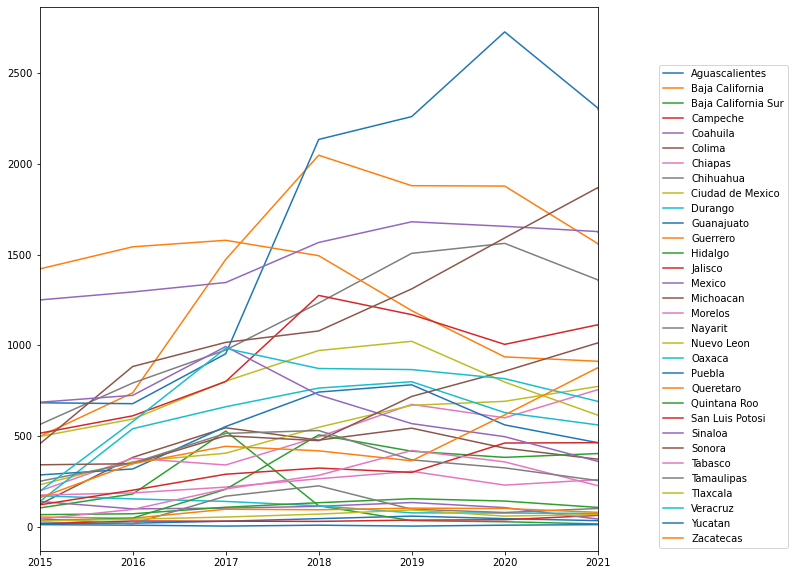

In [12]:
plt.figure(figsize=(10,10))
X = mrdr_gun['anio'].unique()
for state in mrdr_gun.Entidad.unique():
    
    y = [np.nan_to_num(mrdr_gun[(mrdr_gun['Entidad'] == state) & (mrdr_gun['anio'] == year) ]['all']).sum() for year in X]
    
    line = sns.lineplot(x = X,y = y,label = state)
line.legend(loc='right',bbox_to_anchor=(1.35,0.45))
line.set_xlim(2015,2021)


This is a rather messy. It would be more convenient to breakdown this figure and compare states which are closer to each other.

In [13]:
north = ["Sonora","Coahuila","Baja California", "Chihuahua","Tamaulipas","Nuevo Leon"]
north_west = ["Baja California Sur","Sinaloa","Durango","Nayarit","Zacatecas"]
centre_north = ["Jalisco","Aguascalientes","Colima","Michoacan","San Luis Potosi"]
centre = ["Guanajuato","Queretaro","Hidalgo","Mexico","Ciudad de Mexico","Morelos","Tlaxcala","Puebla"]
sur = ["Oaxaca","Chiapas","Veracruz","Tabasco","Campeche","Yucatan","Quintana Roo"]
mex_states = {"North":north,"North West":north_west,"Centre North":centre_north ,"Centre":centre,"South":sur}

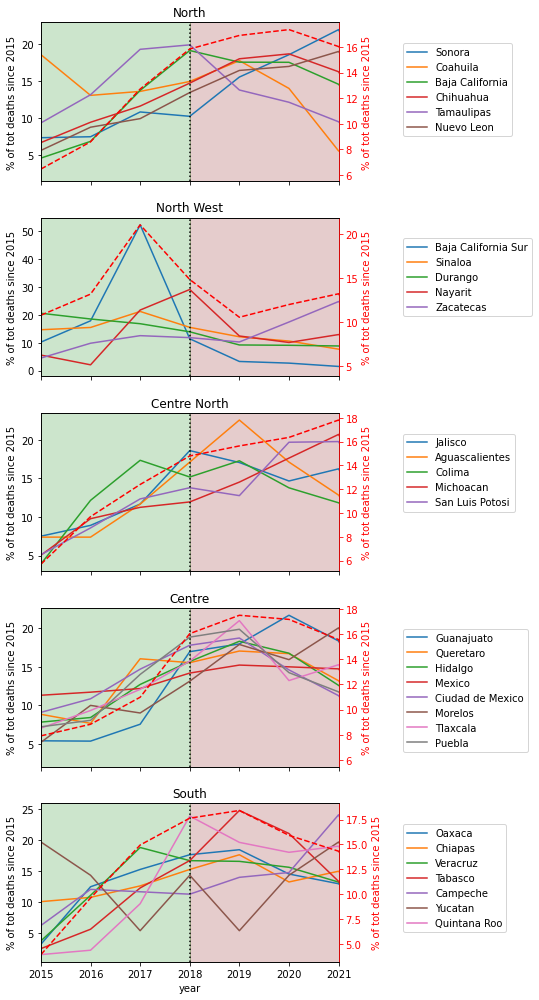

In [14]:


fig,ax = plt.subplots(5,1,figsize = (8,14),sharex = True)


for i,(region,states) in enumerate(mex_states.items()):
    
    for j,state in enumerate(states):
        y = np.array([mrdr_gun[(mrdr_gun['Entidad'] == state) & (mrdr_gun['anio'] == year) ]['all'].sum() for year in X])
        sns.lineplot(x = X,y = y/np.sum(y) * 100, ax = ax[i],label = state)
        
        if j == 0:
            all_states = np.array([y])
        else:
            all_states = np.concatenate([all_states,np.array([y])])

    if i == 0:
        all_gun_deaths = all_states
    else:
        all_gun_deaths = np.concatenate([all_gun_deaths,all_states])
    
    
    all_states = np.sum(all_states,axis=0)
    #print(all_states)
    axt = ax[i].twinx()
    sns.lineplot(x = X,y = all_states/np.sum(all_states)*100,ax=axt,linestyle = '--',color = 'r')
    axt.spines['right'].set_color('red')
    axt.tick_params(axis='y',color = 'r',labelcolor='r')
    axt.set_ylabel(f'% of tot deaths since 2015',color='r')

    ax[i].set_title(region)
    ax[i].legend(bbox_to_anchor = (1.2,0.9))
    ax[i].set_xlim(2015,2021)
    ax[i].set_ylabel(f'% of tot deaths since 2015')
    ax[i].axvline(2018,ls=':',c='k')
    ax[i].axvspan(2018,2022,color='maroon',alpha = 0.2)
    ax[i].axvspan(2015,2018,color='green',alpha = 0.2)
    
ax[-1].set_xlabel("year")
plt.tight_layout()

fig.savefig('deaths_regions.png',dpi=300)

The figure above can clearly demonstrate which states are the ones having the largest quantity of gun related homicides as well as which regions are having more issues with them. The gun related death trend in each region seems to be dominated to the violence corresponding to a state in particular. There are some states in which the violence is increasing constantly (and seamingly linear) whilst some other's murder rate has slowed down. The background colour corresponds to a period with a different president denoted by the colour of their political party and divided by a dotted line.

In [159]:
temp = mrdr_gun.groupby('anio').sum()
coll_per_year = pd.DataFrame()
test2 = []

for year in temp.index:
    vals = [ temp[month][year] for month in temp.columns[-13:-1]]
    coll_per_year[year] = vals
    test2.append(vals)

cont_per_year = np.array(test2).flatten()
    

Text(0, 0.5, 'gun murders per month')

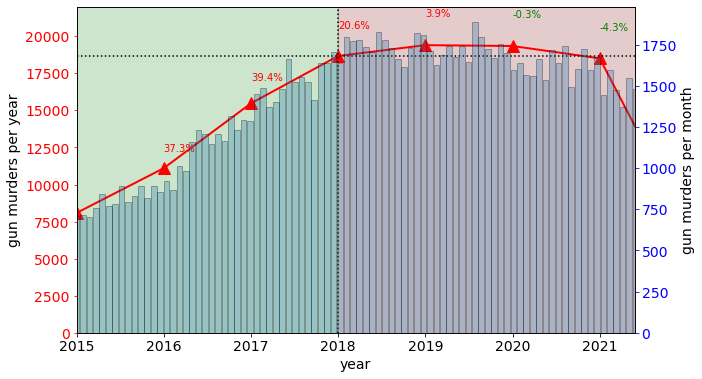

In [235]:
temp.columns[::-12]

pct_change = [all_gun_deaths.sum(axis=0)[i + 1]/all_gun_deaths.sum(axis=0)[i] *100 - 100 for i in range(len(all_gun_deaths.sum(axis=0)) - 2)]

T = np.linspace(2015,2022,len(cont_per_year))

fig,ax = plt.subplots(figsize=(10,6))
axt = ax.twinx()


ax.plot(X,all_gun_deaths.sum(axis=0),color='r',marker='^',markersize=12,linewidth = 2)
axt.bar(T,cont_per_year,alpha = 0.3,edgecolor='k',width=0.065)


ax.axvline(2018,ls=':',c='k')
ax.set_xlim(2015,2021.4)
ax.axvspan(2018,2022,color='maroon',alpha = 0.2)
ax.axvspan(2015,2018,color='green',alpha = 0.2)
ax.axhline(all_gun_deaths.sum(axis=0)[X == 2018],ls = ':',c='k')

for i,change in enumerate(pct_change):
    
    color = 'r'
    if change < 0:
        color='g'
    ax.text(X[i+1],all_gun_deaths.sum(axis=0)[i+1]*1.1,s=f'{np.round(change,1)}%',color=color)

ax.tick_params(axis = 'y',color='r',labelcolor='r')

ax.tick_params(labelsize=fontsize)
ax.set_ylim(0,22000)
ax.set_xlabel('year',fontsize=fontsize)
ax.set_ylabel('gun murders per year',fontsize=fontsize)
axt.tick_params(axis = 'y',color='b',labelcolor='b',labelsize=fontsize)
axt.set_ylabel('gun murders per month',fontsize=fontsize)

The murder rate has been observed to be decreasing since 2019. The total amount of murders has dropped by almost 5% from 2019 to 2021 and the murders per month seem to have a clear trend decrease. It is worth noticing that the murders have a larger variation from month to month since 2019.

The trend in gun related murders seems to be decreasing from 2018 since in 2021, it shows that the murders have been slightly less than in 2018. 

# Map Visualization

This is work in progress. The map will highlight if a state has a positive or negative trend in murders.

In [53]:
mrdr_all.Entidad.unique()

array(['Aguascalientes', 'Baja California', 'Baja California Sur',
       'Campeche', 'Coahuila', 'Colima', 'Chiapas', 'Chihuahua',
       'Ciudad de Mexico', 'Durango', 'Guanajuato', 'Guerrero', 'Hidalgo',
       'Jalisco', 'Mexico', 'Michoacan', 'Morelos', 'Nayarit',
       'Nuevo Leon', 'Oaxaca', 'Puebla', 'Queretaro', 'Quintana Roo',
       'San Luis Potosi', 'Sinaloa', 'Sonora', 'Tabasco', 'Tamaulipas',
       'Tlaxcala', 'Veracruz', 'Yucatan', 'Zacatecas'], dtype=object)

In [16]:
import geopandas as gpd

In [17]:
states_gpd = gpd.read_file('mexstates/mexstates.shp')

In [45]:
"""
Stuff to do:
Make a percentage increase/decrease from 2020 to 2021, 2018 to 2021, and 2015 to 2021 and colour code base on the increase/decrease.
"""

states_gpd = states_gpd.sort_values('ADMIN_NAME')

<AxesSubplot:>

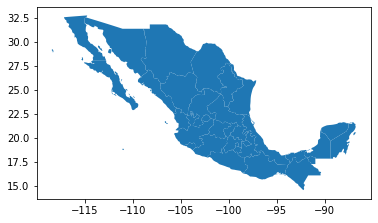

In [47]:
states_gpd.plot()